<a name="intro"></a>

# Notebook 0: Preprocesamiento de datos y equilibrado

## Introducción

Bienvenido al notebook fundamental de nuestra serie, donde haremos el trabajo inicial de preprocesamiento de datos y equilibrado para nuestro análisis de la bomba de agua. Este notebook sirve como base para todos los demas notebooks de modelado subsiguientes, asegurando que los datos en los que se basan sean limpios, confiables y estructurados adecuadamente.

Nuestro conjunto de datos consta de cientos de miles de puntos de datos, cada uno capturando varios aspectos de la operación de la bomba de agua. Sin embargo, estos datos sin procesar presentan problemas ya que contienen muchas filas vacias, valores atípicos, datos no validos, y datos sin balancear con una representación desigual de los estados "Funcionando" y "No funciona" de la bomba.

En este notebook, abordaremos sistemáticamente estos problemas a través de una serie de pasos de limpieza que mitigará cualquier sesgo hacia una clase particular y mejorará la robustez de nuestros modelos futuros.

El resultado de este notebook cuaderno será un conjunto de datos cuidadosamente seleccionado de aproximadamente 6000 puntos de datos, listo para un análisis en profundidad. Este conjunto de datos refinado será la base de la integridad de nuestros modelos predictivos y las ideas que generen, sentando las bases para una evaluación exhaustiva del rendimiento de la bomba de agua. También generamos dos ficheros complementarios de tamaño 150 y 500 que son útiles para desarrollar software sin tener que usar tiempo de computación con el tamaño completo de la muestra

<a name="indice"></a>
# Índice

*   [Introducción](#intro)

*   [Libraries](#librerias)

*   [Carga del conjunto de datos](#cargardatos)

*   [Limpiar los datos NA](#limpiana)

*   [Estado inicial del balanceo de datos](#estadoinicial)

*   [Seleccionamos datos a eliminar](#eliminar)

*   [Estado final después del balanceo](#final)

*   [Guardamos los datos para el resto de notebooks](#guardar)



<a name="librerias"></a>

## Librerias

[Numpy](https://es.wikipedia.org/wiki/NumPy) es un paquete fundamental para la computación científica en Python, que proporciona soporte para matrices y arreglos multidimensionales de gran tamaño, junto con una colección de funciones matemáticas para operar eficientemente en estos arreglos.

[Pandas](https://es.wikipedia.org/wiki/Pandas_(software)) es una biblioteca que ofrece estructuras de datos y herramientas de análisis de datos de alto rendimiento y fáciles de usar para Python. Su estructura de datos principal es el DataFrame, que permite almacenar y manipular datos tabulares en filas de observaciones y columnas de variables.

[Matplotlib](https://es.wikipedia.org/wiki/Matplotlib) es una biblioteca de trazado de gráficos para Python y su extensión matemática numérica, NumPy. Proporciona una API orientada a objetos para incrustar gráficos en aplicaciones utilizando herramientas de interfaz gráfica de usuario de propósito general como Tkinter, wxPython, Qt o GTK.

El módulo "random" implementa generadores de números pseudoaleatorios para diversas distribuciones y es útil para tareas como la selección aleatoria de muestras y la elección de elementos aleatorios de un rango o colección.

Google Colab es un servicio en la nube gratuito basado en Jupyter Notebooks que admite GPU gratuitas e integra con Google Drive. Se utiliza para la educación e investigación en aprendizaje automático, proporcionando un entorno fácil de usar para escribir y ejecutar código Python, lo cual es especialmente beneficioso para proyectos colaborativos.

In [1]:
# Librerias generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Random numbers
import random

# Google Drive library
from google.colab import drive

[(*volver al índice*)](#indice)

<a name="cargardatos"></a>

## Carga del conjunto de datos

In [48]:
# Montar el disco de drive
drive.mount('/content/drive')
# -- Dónde está el directorio principal
PROJECT_FOLDER = "/content/drive/My Drive/Colab Notebooks/"
# -- Hay que usar sensor.csv de 120MB
DATA_FILE      = "/datos/sensor.csv"

# Cárgamos el archivo en un dataframe
# NOTA: La columna para el sensor 15 está vacía, esto es correcto
data = pd.read_csv( PROJECT_FOLDER + DATA_FILE, sep = ",", header=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


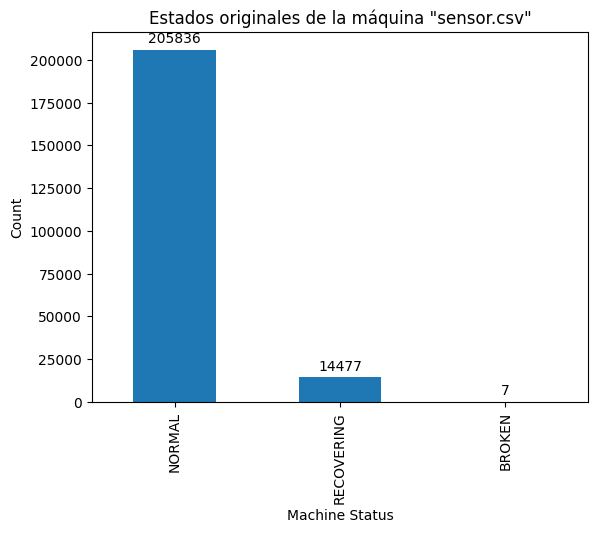

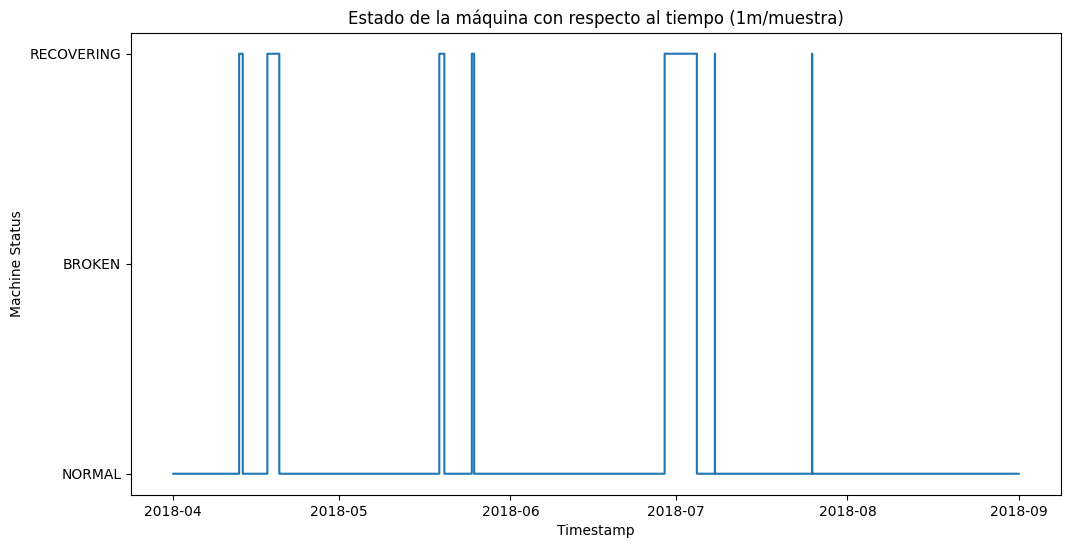

In [49]:
# Vamos a estudiar que pasa con los estados de la máquina

# Convertimos el time stamp a objecto data
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Contamos cada estado
status_counts = data['machine_status'].value_counts()
bar_plot = status_counts.plot(kind='bar')
plt.xlabel('Machine Status')
plt.ylabel('Count')
plt.title('Estados originales de la máquina "sensor.csv"')

# Annotate the total number above each column
for bar in bar_plot.patches:
    bar_plot.annotate(format(bar.get_height(), '.0f'),
                      (bar.get_x() + bar.get_width() / 2,
                       bar.get_height()), ha='center', va='center',
                       size=10, xytext=(0, 8),
                       textcoords='offset points')

plt.show()

# Vemos que pasa a lo largo del tiempo
status_mapping = {'NORMAL': 0, 'BROKEN': 1, 'RECOVERING': 2}
data['status_mapped'] = data['machine_status'].map(status_mapping)

plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['status_mapped'], drawstyle='steps-post')
plt.xlabel('Timestamp')
plt.ylabel('Machine Status')
plt.yticks(ticks=[0, 1, 2], labels=['NORMAL', 'BROKEN', 'RECOVERING'])
plt.title('Estado de la máquina con respecto al tiempo (1m/muestra)')
plt.show()

In [50]:
data.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status,status_mapped
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL,0
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL,0
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL,0
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL,0
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL,0


In [51]:
# Eliminamos las dos primeras columnas que son la fecha y el índice
data = data.drop(data.columns[[0]], axis=1) # axis = 1 significa columna
data = data.drop(data.columns[[0]], axis=1)

# Cambiamos los estados originales de Y de esta manera:
#      {NORMAL, BROKEN, RECOVERING}
#      {1     , 0     , 0}
data['new'] = 1
for i in range(0,data.shape[0]):
  if ( (data.iat[i, data.shape[1]-3] ) != "NORMAL"):
    data.iat[i, data.shape[1]-1] = 0

# Borramos la columna de Y antigua
data = data.drop(data.columns[[  data.shape[1]-2  ]], axis=1)
data = data.drop(data.columns[[  data.shape[1]-2  ]], axis=1)

In [52]:
data.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,new
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,1
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,1
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,1
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,1
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,1


[(*volver al índice*)](#indice)

<a name="limpiana"></a>

## Limpiar valores NA

In [53]:
# --------------------------------------
# Limpiar NAs de las tablas
# --------------------------------------

# Hasta aquí los datos están listos para ser usados. Pero vamos a ver que pasa
# cuando limpiamos los datos bien, ya sea interpolando o quitando columnas y
# filas enteras

# Comprobamos el estado de salud de los datos
data.isna().sum()

# Esto nos dice que las columnas 15 y 50 son una patata, las quitamos
# directamente.
dataTemp = data.copy()
del dataTemp['sensor_15']
del dataTemp['sensor_50']

# Buscamos fila por fila y quitamos las que tengan NAs
deleteTheseRows = [False]*dataTemp.shape[0]
for i in range(0, dataTemp.shape[0]):

  if (   dataTemp.iloc[i,].isna().sum()  >= 1   ) :
    deleteTheseRows[i] = True

print("Total eliminadas ", sum(deleteTheseRows))

#Aquí tenemos todos los datos originales sin filas NA
dataCurrent = dataTemp.drop(dataTemp[deleteTheseRows].index)

Total eliminadas  24505


[(*volver al índice*)](#indice)

<a name="estadoinicial"></a>

## Estado inicial del balanceo de datos

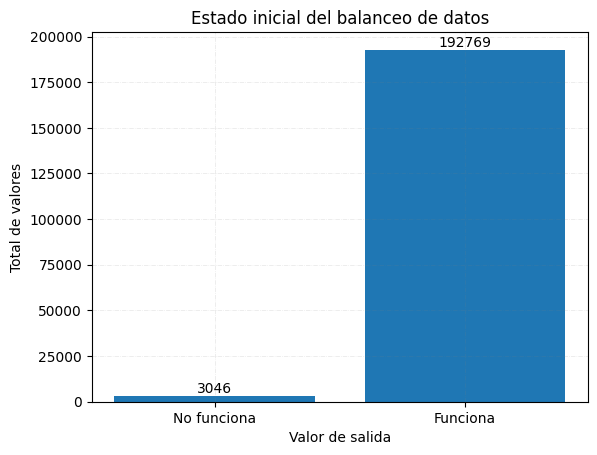

In [54]:
# ------------------------------------------------------------------------------
# Comprobar el estado de balanceo de datos inicial
# ------------------------------------------------------------------------------
# Separammos los datos y definimos X e Y
X = dataCurrent.iloc[:, 0:dataCurrent.shape[1]-1]
Y = dataCurrent.iloc[:,   dataCurrent.shape[1]-1]

# Contamos las Y
salida_data = { 'No funciona':0 ,
                'Funciona':0}

salida_data['Funciona']    = sum(Y == 1)
salida_data['No funciona'] = sum(Y == 0)

# Hacer el barplot
# ---- Seleccionar datos
balanceoPlot = plt.bar(salida_data.keys(), salida_data.values())
# ---- Añadir las líneas horizontales
plt.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)
# ---- Rótulos
plt.xlabel("Valor de salida")
plt.ylabel("Total de valores")
plt.title("Estado inicial del balanceo de datos")
# ---- Números
for bar in balanceoPlot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

[(*volver al índice*)](#indice)

<a name="eliminar"></a>

## Seleccionamos datos a eliminar

In [55]:
# ------------------------------------------------------------------------------
# Elegimos las Y=1 de forma aleatoria
# ------------------------------------------------------------------------------
# Comprobamos que filas tienen 0s y cuales tienen 1s
trueRows  = [i for i, x in enumerate(Y) if x == 1]
falseRows = [i for i, x in enumerate(Y) if x == 0]

# Elegimos las filas con 1s de forma aleatoria
finalRows = random.choices(trueRows, k = salida_data['No funciona'])

# Añadimos las filas que tienen 0s
finalRows = finalRows + falseRows
finalRows.sort()

# Actualizamos los datos con las filas seleccionadas
dataCurrent = dataCurrent.iloc[ finalRows  , ]



[(*volver al índice*)](#indice)

<a name="final"></a>

## Estado final después del balanceo

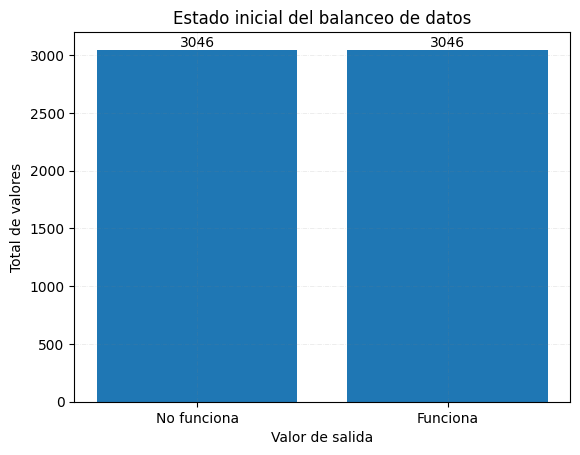

In [57]:
# ------------------------------------------------------------------------------
# Comprobar el estado de balanceo de datos final
# ------------------------------------------------------------------------------
# Separammos los datos y definimos X e Y
X = dataCurrent.iloc[:, 0:dataCurrent.shape[1]-1]
Y = dataCurrent.iloc[:,   dataCurrent.shape[1]-1]

# Contamos las Y
salida_data = { 'No funciona':0 ,
                'Funciona':0}

salida_data['Funciona']    = sum(Y == 1)
salida_data['No funciona'] = sum(Y == 0)

# Hacer el barplot
# ---- Seleccionar datos
balanceoPlot = plt.bar(salida_data.keys(), salida_data.values())
# ---- Añadir las líneas horizontales
plt.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)
# ---- Rótulos
plt.xlabel("Valor de salida")
plt.ylabel("Total de valores")
plt.title("Estado inicial del balanceo de datos")
# ---- Números
for bar in balanceoPlot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

[(*volver al índice*)](#indice)

<a name="guardar"></a>

## Guardamos los datos para el resto de notebooks

Aquí elegimos cuantas Ys de las 6000 posibles que tenemos, ponemos en el conjunto de datos final.

Hacemos 3 versiones, una con 300ys (150y = 1, 150y = 0), otra con 1000ys (300y = 1, 300y = 0), y la última con todos los 12000 datos posibles (6000y en cada grupo).

In [ ]:
# ------------------------------------------------------------------------------
# Guardamos los datos en el drive
# ------------------------------------------------------------------------------

# Preparamos el nombre de los ficheros
VERSION_150_X   = 'Datos_balanceados_X_150.txt'
VERSION_500_X   = 'Datos_balanceados_X_500.txt'
VERSION_6000_X  = 'Datos_balanceados_X_3000.txt'
VERSION_150_Y   = 'Datos_balanceados_Y_150.txt'
VERSION_500_Y   = 'Datos_balanceados_Y_500.txt'
VERSION_6000_Y  = 'Datos_balanceados_Y_3000.txt'

BASE_FOLDER = PROJECT_FOLDER + 'Resultados/Balanceo de datos/'


# Versión con 150 Ys, unos 300 datos en total
# El número 42 es la semilla aleatoria a usar
y_1_indices = Y[Y == 1].sample(n=150, random_state=42).index
y_0_indices = Y[Y == 0].sample(n=150, random_state=42).index
Y_150_1 = Y.loc[y_1_indices]
X_150_1 = X.loc[y_1_indices]
Y_150_0 = Y.loc[y_0_indices]
X_150_0 = X.loc[y_0_indices]
Y_150 = pd.concat([Y_150_1, Y_150_0])
X_150 = pd.concat([X_150_1, X_150_0])

# Versión con 500 Ys, unos 1000 datos en total
y_1_indices = Y[Y == 1].sample(n=500, random_state=42).index
y_0_indices = Y[Y == 0].sample(n=500, random_state=42).index
Y_500_1 = Y.loc[y_1_indices]
X_500_1 = X.loc[y_1_indices]
Y_500_0 = Y.loc[y_0_indices]
X_500_0 = X.loc[y_0_indices]
Y_500 = pd.concat([Y_500_1, Y_500_0])
X_500 = pd.concat([X_500_1, X_500_0])

# Versión completa con 3000 Ys, unos 6000 datos en total
# (No hay que tocar nada)


# Guardamos todo
np.savetxt(BASE_FOLDER + VERSION_150_X,  X_150)
np.savetxt(BASE_FOLDER + VERSION_500_X,  X_500)
np.savetxt(BASE_FOLDER + VERSION_6000_X, X)
np.savetxt(BASE_FOLDER + VERSION_150_Y,  Y_150)
np.savetxt(BASE_FOLDER + VERSION_500_Y,  Y_500)
np.savetxt(BASE_FOLDER + VERSION_6000_Y, Y)

[(*volver al índice*)](#indice)